## Retrieving, preparing and visualizing TROPOMI data: AEROSOLS

In this notebook I am retrievin sentinel 5P data (TROPOMI, in particular aerosol properties), loading the netCDF files with xarray, dealing with (resampling, average, preping) and plotting them.

In [1]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy.ma as ma

I am retrieving data from sentinel 5P mission using the python API and sentinelsat library. Is very easy:
- If you are retrieving data from sentinel 1, 2 or 3 missions then you need credentials (sign up for free on the [sentinel scihub](https://scihub.copernicus.eu/) 
- If your intention is to retrieve data from TROPOMI (sentinel 5) then user and password are **s5pguest**). 

For querying the products that you may need you have to specify a few things (note that there are more arguments than I just used)

- **Footprint**: the polygon you want (the piece of earth you want to look at). You can create a geosjson file very easily here
- **Date**: one option is to indicated as below
- **platform**: which mission 
- **Producttype**: refering to diferent channels and products

In [4]:
os.chdir('C:/Users/Lucia/Desktop/GITHUB/sentinel5P-retrieval')

In [3]:

api = SentinelAPI(user='s5pguest', password='s5pguest', api_url='https://s5phub.copernicus.eu/dhus')

footprint = geojson_to_wkt(read_geojson('map.geojson'))
products = api.query(footprint,
                     date =  ('NOW-7DAYS', 'NOW'),
                     platformname = 'Sentinel-5 Precursor',
                     producttype = 'L2__AER_LH')


In [ ]:
api.download_all(products)


The .nc files are now stored in the current working directory. For opening the .nc files I'll be using the **xarray** library. There is also **netCDF4** library but I think xarray is better but little bit more complicated. I am opening all the files downloaded.

Note that all the files will be concatenated by the time dimension.



In [5]:

files = os.listdir(os.getcwd())  
nc_files = []
for file in files:
   if file.endswith('.nc'):
       nc_files.append(file)
       
     

In [6]:
arr = xr.open_mfdataset(nc_files,concat_dim= 'time', combine = 'nested',group='PRODUCT',
                        engine ='netcdf4', decode_coords=True)

### Reading and interpreting .nc files

nc files (or netCDF files) contains -apart from the target data- metadata for the user to open it properly and understand how is it structured, in which dimention is time, x (longitudes), y (latitudes) and variables (these last one could be temperature, pressure, NO2 concentration, Aerosol optical depth, etc).

When xarray open multiple .nc files it isually store every file concatenated by the time dimension. The picture below show how geodata is usually structured.   


Also xarray does not open this arrays as numpy arrays and that is related with efficency. So don't try to see an array, it is there, chunked stored as a  'xarray.core.dataset.Dataset' type. Actually it doesnt load the whole array into the memory which is pretty convenient.Most of the time we are dealing with laaaaaarge datasets and xarray does a lot of the work for us to open and deal with them quickly and this is the way. Xarray documentation is [here](https://docs.xarray.dev/en/stable/) and is very complete.

*Note: If you want to load the values into memory you need to add .values as the example above. If you want to do operations with the data (for example mean, or adding something or just manipulating) it is not really neccesary in most of the cases to load the values. Once you load them, python stored this as a numpy array which for only one time is not big deal but for the 60 times that this dataset has is a problem.* 

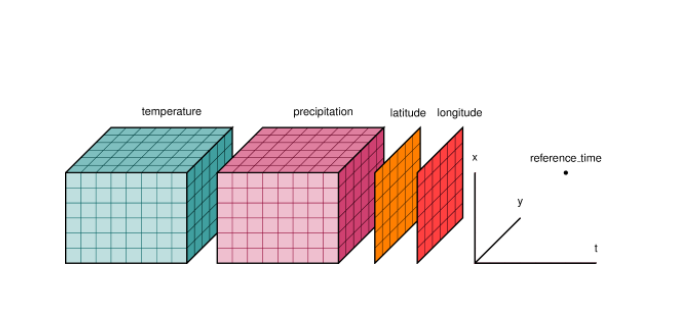

A nice way to see which variables are contained in those is just to print our multiples netCDF file recently loaded.


In [7]:
print(arr)
print(type(arr))

<xarray.Dataset>
Dimensions:                         (scanline: 4172, ground_pixel: 448, time: 12, corner: 4, state_vector_length: 2)
Coordinates:
  * scanline                        (scanline) float64 0.0 1.0 ... 4.171e+03
  * ground_pixel                    (ground_pixel) float64 0.0 1.0 ... 447.0
  * time                            (time) datetime64[ns] 2022-05-19 ... 2022...
  * corner                          (corner) float64 0.0 1.0 2.0 3.0
  * state_vector_length             (state_vector_length) object nan nan
    latitude                        (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 448), meta=np.ndarray>
    longitude                       (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4172, 448), meta=np.ndarray>
Data variables:
    delta_time                      (time, scanline) datetime64[ns] dask.array<chunksize=(1, 4172), meta=np.ndarray>
    time_utc                        (time, scanline) object dask.array<chunksize=(1, 

In [8]:
#Example for loading into memory (and for further plotting)

lons = (arr.variables['longitude'].values)[0,:,:]
lats = (arr.variables['latitude'].values)[0,:,:]
aerosol_mid = ((arr['aerosol_mid_height'].values)[0,:,:]) #loading only the first time

print(type(aerosol_mid))

<class 'numpy.ndarray'>



My aim is to plot last week aerosols (average) in the region selected. That means that I need to perform an average.


In [9]:
arr_monthly_avg = arr.mean("time", skipna = True)
print(arr_monthly_avg)

<xarray.Dataset>
Dimensions:                         (scanline: 4172, ground_pixel: 448, corner: 4, state_vector_length: 2)
Coordinates:
  * scanline                        (scanline) float64 0.0 1.0 ... 4.171e+03
  * ground_pixel                    (ground_pixel) float64 0.0 1.0 ... 447.0
  * corner                          (corner) float64 0.0 1.0 2.0 3.0
  * state_vector_length             (state_vector_length) object nan nan
Data variables:
    qa_value                        (scanline, ground_pixel) float32 dask.array<chunksize=(4172, 448), meta=np.ndarray>
    aerosol_mid_pressure            (scanline, ground_pixel) float32 dask.array<chunksize=(4172, 448), meta=np.ndarray>
    aerosol_mid_height              (scanline, ground_pixel) float32 dask.array<chunksize=(4172, 448), meta=np.ndarray>
    aerosol_mid_pressure_precision  (scanline, ground_pixel) float32 dask.array<chunksize=(4172, 448), meta=np.ndarray>
    aerosol_mid_height_precision    (scanline, ground_pixel) float32 da

Also I am dividing by 1000 aerosol height in order to change the units from meters to kilometers

In [10]:
km_arr_monthly_avg = arr_monthly_avg.variables['aerosol_mid_height']/1000
km_arr_monthly_avg = km_arr_monthly_avg.values
print(km_arr_monthly_avg)

[[      nan 1.040325  1.2253376 ... 2.7593923 2.6557162 2.6107621]
 [      nan       nan       nan ... 2.6606033 2.0960662 2.003993 ]
 [1.0348657       nan       nan ... 3.4705517 2.507335  2.4586675]
 ...
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]]


C:\Users\Lucia\anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Plotting 

I am masking values over 12km for a tidy plot

**IMPORTANT**: For plotting, it is need to load the array into memory (that is why y add .values in aboves cell)

C:\Users\Lucia\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


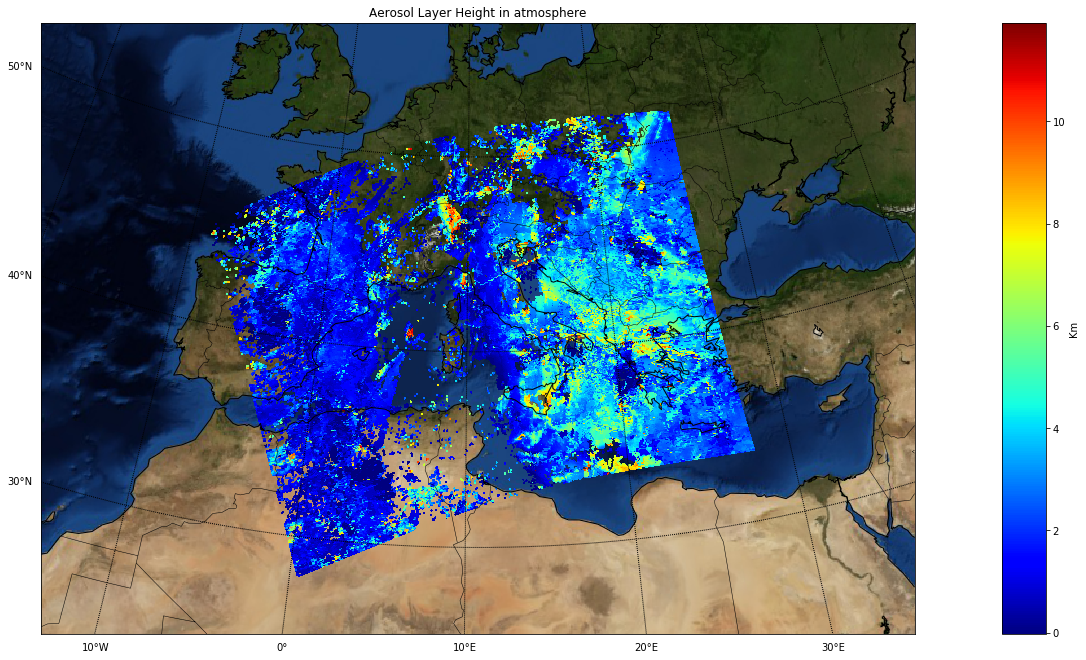

In [13]:
nan = float('nan')
km_arr_monthly_avg [km_arr_monthly_avg > 12 ] = nan #masking


lon_0 = np.nanmean(lons)
lat_0 = np.nanmean(lats)

#Creating basemap

m = Basemap(width=5000000,height=3500000,
            resolution='l',projection='lcc',\
            lat_ts=40,lat_0=lat_0,lon_0=lon_0)

xi, yi = m(lons, lats)

# Plot Data
plt.figure(figsize=(18,18))
plt.title('Aerosol Layer Height in atmosphere')

cs = m.pcolor(xi,yi,np.squeeze(km_arr_monthly_avg), cmap='jet')

#Add blue marbel background

m.bluemarble()

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# Add Colorbar

cbar = m.colorbar(cs, location='right', pad="10%")
cbar.set_label('Km')

plt.show()

